Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [60]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy
import matplotlib.pyplot as plt


## The *Nim* and *Nimply* classes

In [61]:
Nimply = namedtuple("Nimply", "row, num_objects")


In [62]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects


## Sample (and silly) startegies 

In [63]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [64]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [65]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


In [66]:
import numpy as np


def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    return ply


## Oversimplified match

In [67]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, pure_random)

nim = Nim(5)
logging.info(f"init : {nim}")
player = 0
while nim:
    ply = strategy[player](nim)
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply)
    logging.info(f"status: {nim}")
    player = 1 - player
logging.info(f"status: Player {player} won!")


INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=1)
INFO:root:status: <1 2 5 7 9>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=1)
INFO:root:status: <1 2 4 7 9>
INFO:root:ply: player 0 plays Nimply(row=3, num_objects=4)
INFO:root:status: <1 2 4 3 9>
INFO:root:ply: player 1 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 2 4 3 9>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=2)
INFO:root:status: <0 2 4 3 7>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 1 4 3 7>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=4)
INFO:root:status: <0 1 4 3 3>
INFO:root:ply: player 1 plays Nimply(row=4, num_objects=2)
INFO:root:status: <0 1 4 3 1>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=1)
INFO:root:status: <0 1 4 3 0>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=3)
INFO:root:status: <0 1 4 0 0>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=4)
INFO:root:status: <0 1

## 100 Matches

In [68]:
def draw_pie_chart(win_rate, title):
    labels = ['Wins', 'Losses']
    sizes = [win_rate, 100 - win_rate]
    colors = ['#4CAF50', '#FF5252']

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
    
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    ax.axis('equal')  
    
    plt.title(title)
    plt.show()

## Optimal starts first

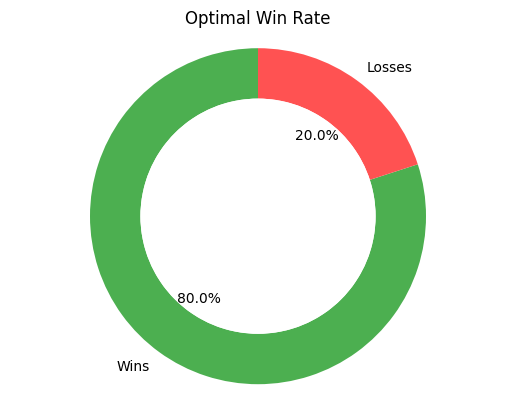

In [69]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, pure_random)

count_win = 0

for _ in range(100):
    nim = Nim(5)
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    if player == 0 :
        count_win += 1

draw_pie_chart(count_win, "Optimal Win Rate")

## Optimal starts second

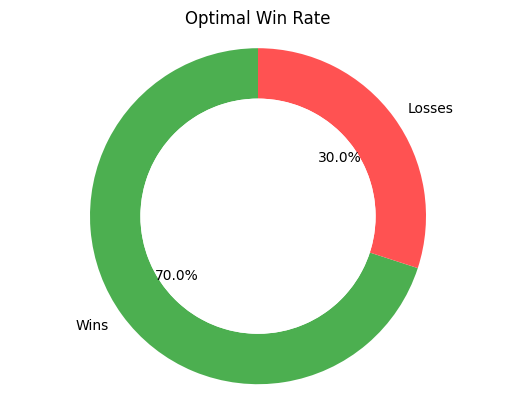

In [70]:
logging.getLogger().setLevel(logging.INFO)

strategy = (pure_random, optimal)

count_win = 0

for _ in range(100):
    nim = Nim(5)
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    if player == 1 :
        count_win += 1

draw_pie_chart(count_win, "Optimal Win Rate")

## Pure Random

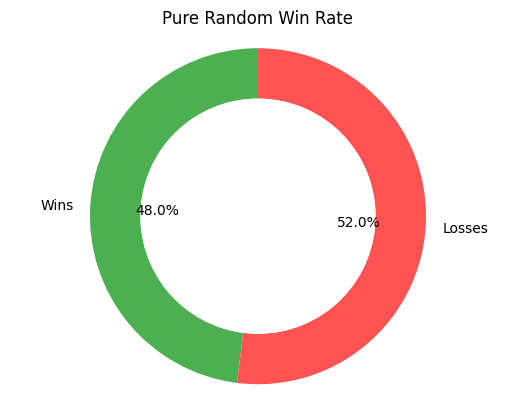

In [71]:
logging.getLogger().setLevel(logging.INFO)

strategy = (pure_random, pure_random)

count_win = 0

for _ in range(100):
    nim = Nim(5)
    player = 0
    while nim:
        ply = strategy[player](nim)
        nim.nimming(ply)
        player = 1 - player
    if player == 0 :
        count_win += 1

draw_pie_chart(count_win, "Pure Random Win Rate")